# **`Cats vs Dogs CNN 이용해서 불러오기
`**

- using VGG16

In [1]:
#VGG모델을 이용한 고양이 개 분류

In [2]:
import os
import shutil
import random

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, Add, MaxPooling2D, Dense, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# SciPy and Sklearn for additional functionalities
import scipy as sp
from scipy import ndimage
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [3]:
(train_data, validation_data, test_data), metadata = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], with_info = True, as_supervised=True,)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteSRAHFG/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


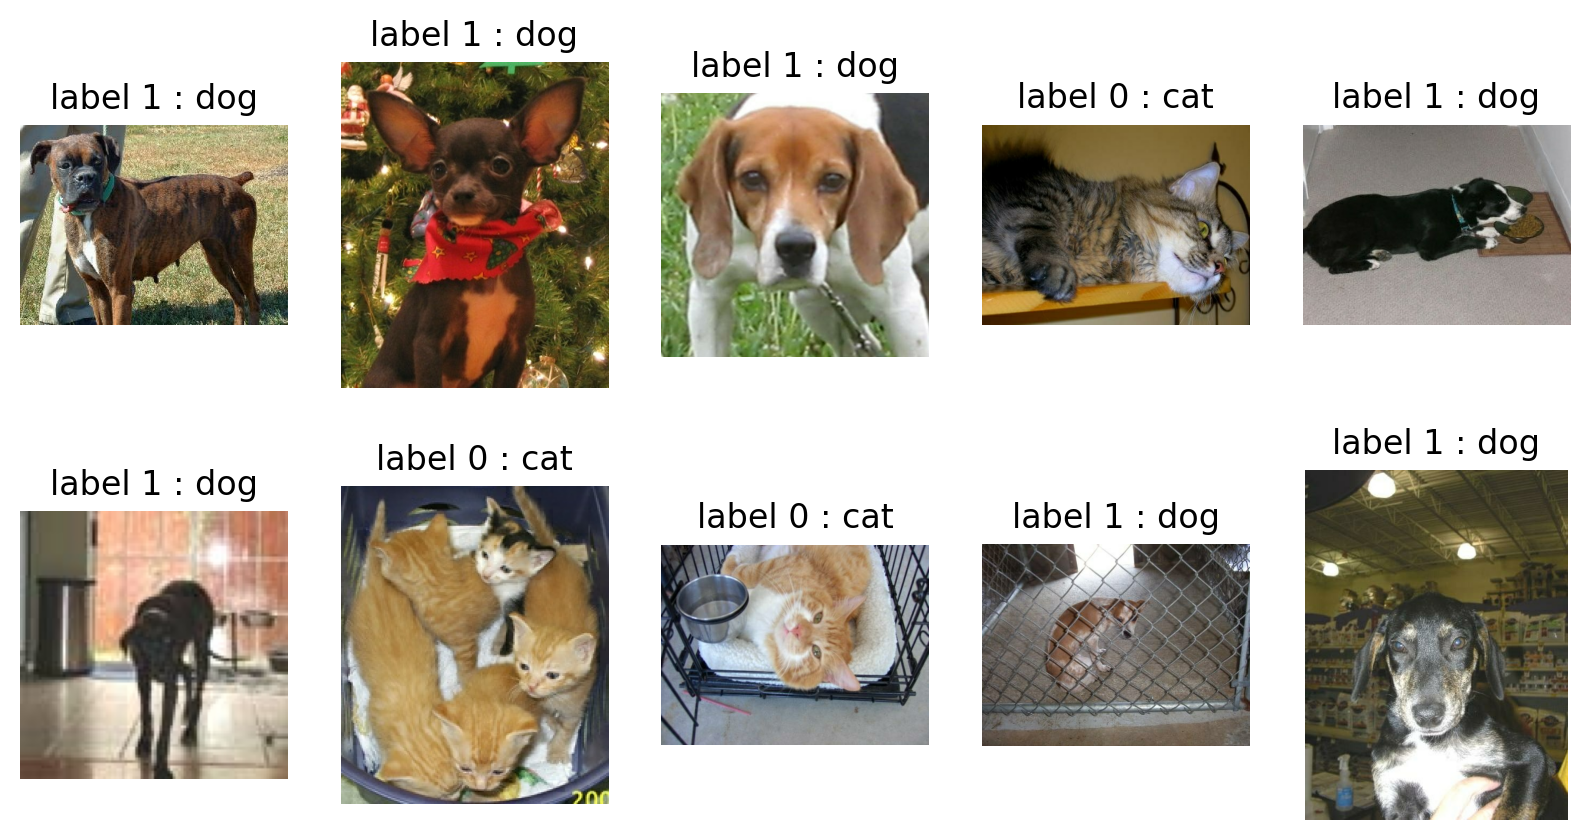

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10,5))

get_label_name = metadata.features['label'].int2str

# 라벨링 및 확인
for idx, (image, label) in enumerate(train_data.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label} : {get_label_name(label)}')
    plt.axis('off')

In [5]:
# 이미지 포맷(사이즈 통일)
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1	# 픽셀 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [6]:
#map을 이용해 데이터를 받아온다
train = train_data.map(format_example)
validation = validation_data.map(format_example)
test = test_data.map(format_example)

print(train)
print(validation)
print(test)

<_MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


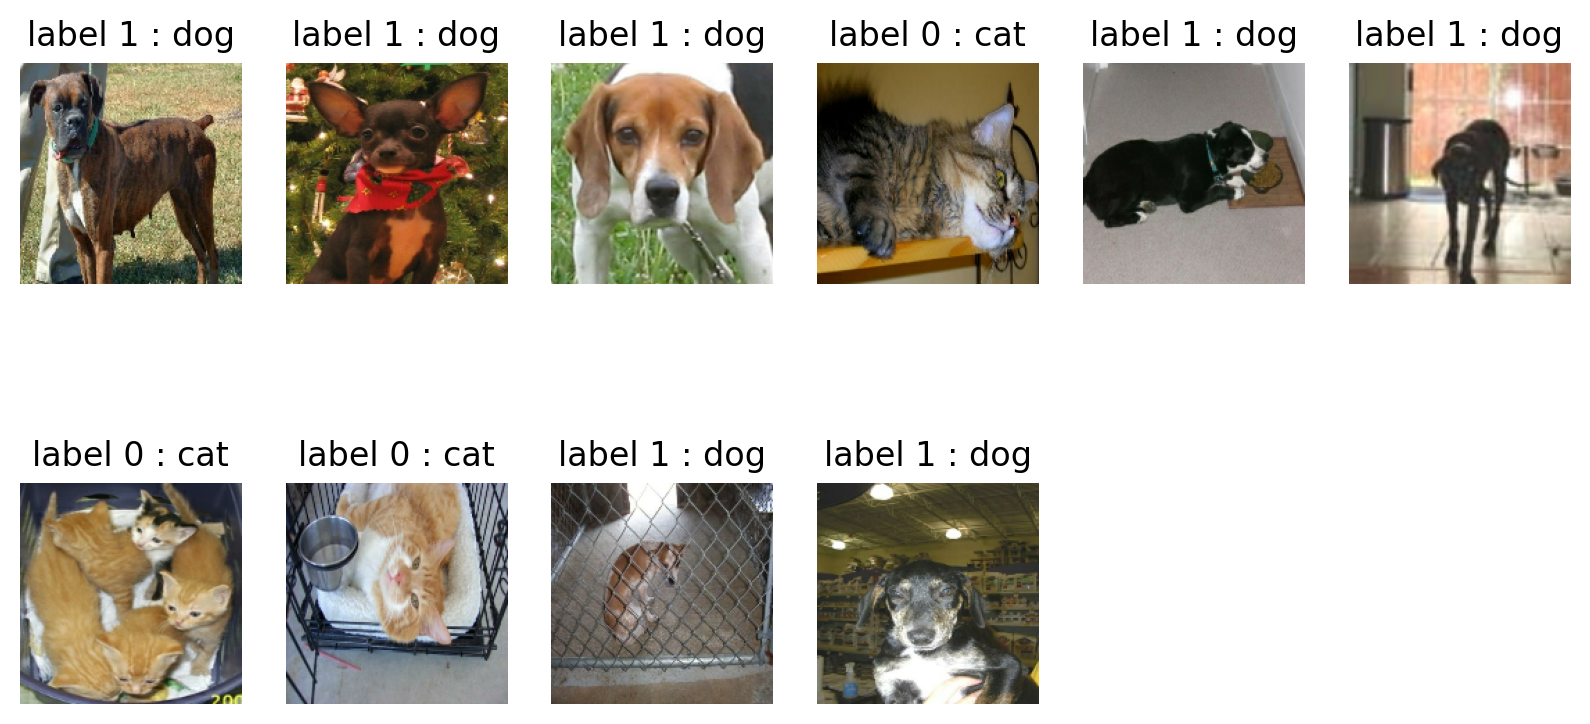

In [7]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str #str로 변환

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 6, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label} : {get_label_name(label)}')
    plt.axis('off')

In [8]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

# model = Sequential([
#     Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
#     MaxPooling2D(),
#     Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Flatten(),
#     Dense(units=512, activation='relu'),
#     Dense(units=2, activation='softmax')
#     ])

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout

# VGG16 모델 불러오기 (이미 학습된 가중치를 사용)
base_model = VGG16(input_shape=(160, 160, 3), include_top=False, weights='imagenet')

# VGG16의 합성곱층을 동결
for layer in base_model.layers:
    layer.trainable = False

# 모델 구성
model = Sequential([
    base_model,
    Flatten(),
    Dense(units=512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(units=2, activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [10]:
# import tensorflow as tf
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten

# # ResNet50 모델 불러오기 (이미 학습된 가중치를 사용)
# resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

# # ResNet50의 합성곱층을 동결
# for layer in resnet_model.layers:
#     layer.trainable = False

# # 새로운 모델 구성
# model = Sequential([
#     resnet_model,
#     Flatten(),
#     Dense(units=128, activation='relu'),
#     Dense(units=1, activation='sigmoid')
# ])

# # 모델 컴파일
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # 모델 요약
# model.summary()


In [18]:
learning_rate = 0.0001

In [19]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [20]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [21]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [22]:
#학습 전 정확도 측정
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss : {:.2f}".format(loss0))
print("initial accuracy : {:.2f}".format(accuracy0))

20/20 [==============================] - 2s 65ms/step - loss: 0.7820 - accuracy: 0.4594
initial loss : 0.78
initial accuracy : 0.46


In [23]:
#학습 후 정확도 4에팍
EPOCHS = 5
history = model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 49s 77ms/step - loss: 0.2231 - accuracy: 0.9149 - val_loss: 0.1855 - val_accuracy: 0.9222
Epoch 2/5
582/582 [==============================] - 46s 78ms/step - loss: 0.1423 - accuracy: 0.9431 - val_loss: 0.1518 - val_accuracy: 0.9402
Epoch 3/5
582/582 [==============================] - 50s 82ms/step - loss: 0.1246 - accuracy: 0.9508 - val_loss: 0.1463 - val_accuracy: 0.9394
Epoch 4/5
582/582 [==============================] - 53s 89ms/step - loss: 0.1048 - accuracy: 0.9567 - val_loss: 0.1524 - val_accuracy: 0.9424
Epoch 5/5
582/582 [==============================] - 48s 80ms/step - loss: 0.0995 - accuracy: 0.9615 - val_loss: 0.1703 - val_accuracy: 0.9372


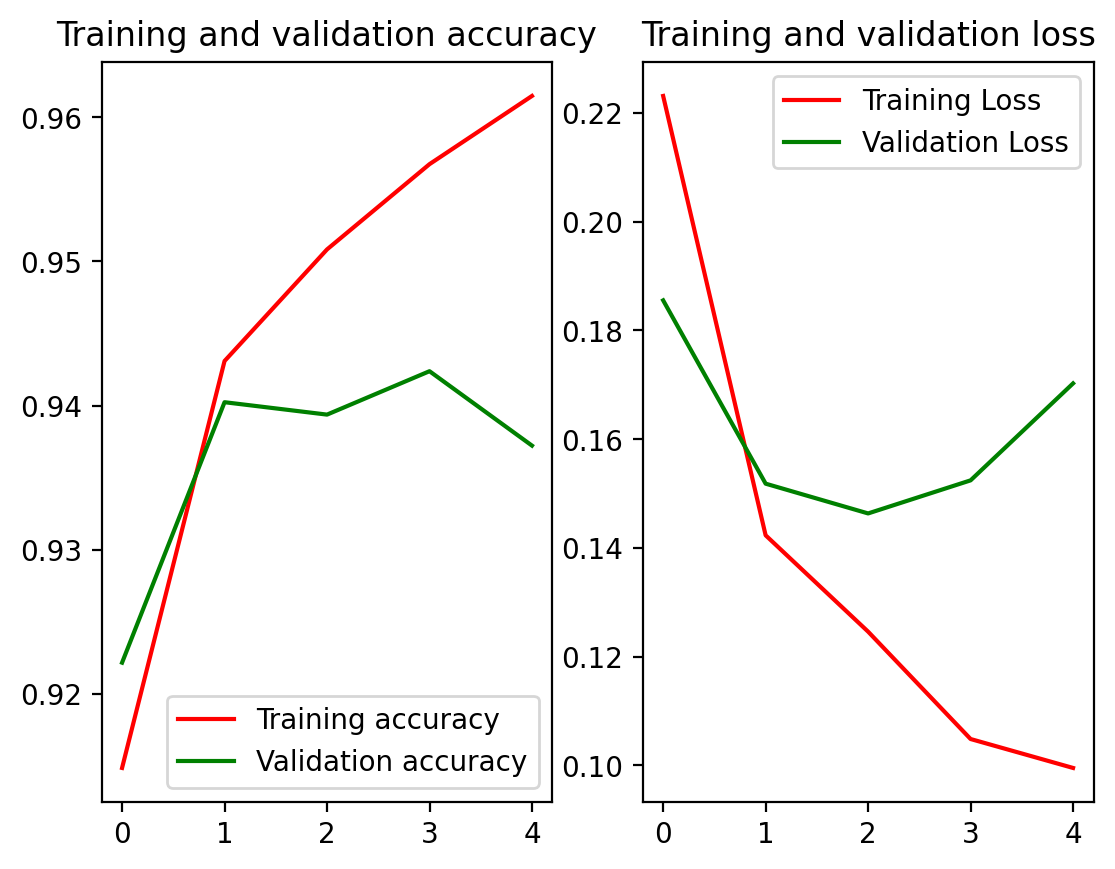

<Figure size 640x480 with 0 Axes>

In [38]:
# 정확도와 손실 확인
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.show()

### VGG 은닉층 추가

In [67]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout

# VGG16 모델 불러오기 (이미 학습된 가중치를 사용)
base_model = VGG16(input_shape=(160, 160, 3), include_top=False, weights='imagenet')

# VGG16의 합성곱층을 동결
for layer in base_model.layers:
    layer.trainable = False

# 모델 구성
model = Sequential([
    base_model,
    Flatten(),
    Dense(units=64, activation='relu'),  # 첫 번째 은닉층 유닛 수를 줄임
    BatchNormalization(),
    Dropout(0.5),
    Dense(units=128, activation='relu'),   # 두 번째 은닉층 추가
    BatchNormalization(),
    Dropout(0.5),
    Dense(units=2, activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# 손실함수 : binary_crossentropy 로 변경


In [68]:
learning_rate = 0.0001

In [69]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [70]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [71]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [72]:
#학습 전 정확도 측정
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss : {:.2f}".format(loss0))
print("initial accuracy : {:.2f}".format(accuracy0))

20/20 [==============================] - 2s 64ms/step - loss: 0.7561 - accuracy: 0.4328
initial loss : 0.76
initial accuracy : 0.43


In [ ]:
#학습 후 정확도 4에팍
EPOCHS = 5
history = model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 49s 78ms/step - loss: 0.4016 - accuracy: 0.8426 - val_loss: 0.1522 - val_accuracy: 0.9428
Epoch 2/5
582/582 [==============================] - 47s 77ms/step - loss: 0.2319 - accuracy: 0.9114 - val_loss: 0.1527 - val_accuracy: 0.9364
Epoch 3/5
477/582 [=======================>......] - ETA: 7s - loss: 0.1973 - accuracy: 0.9251

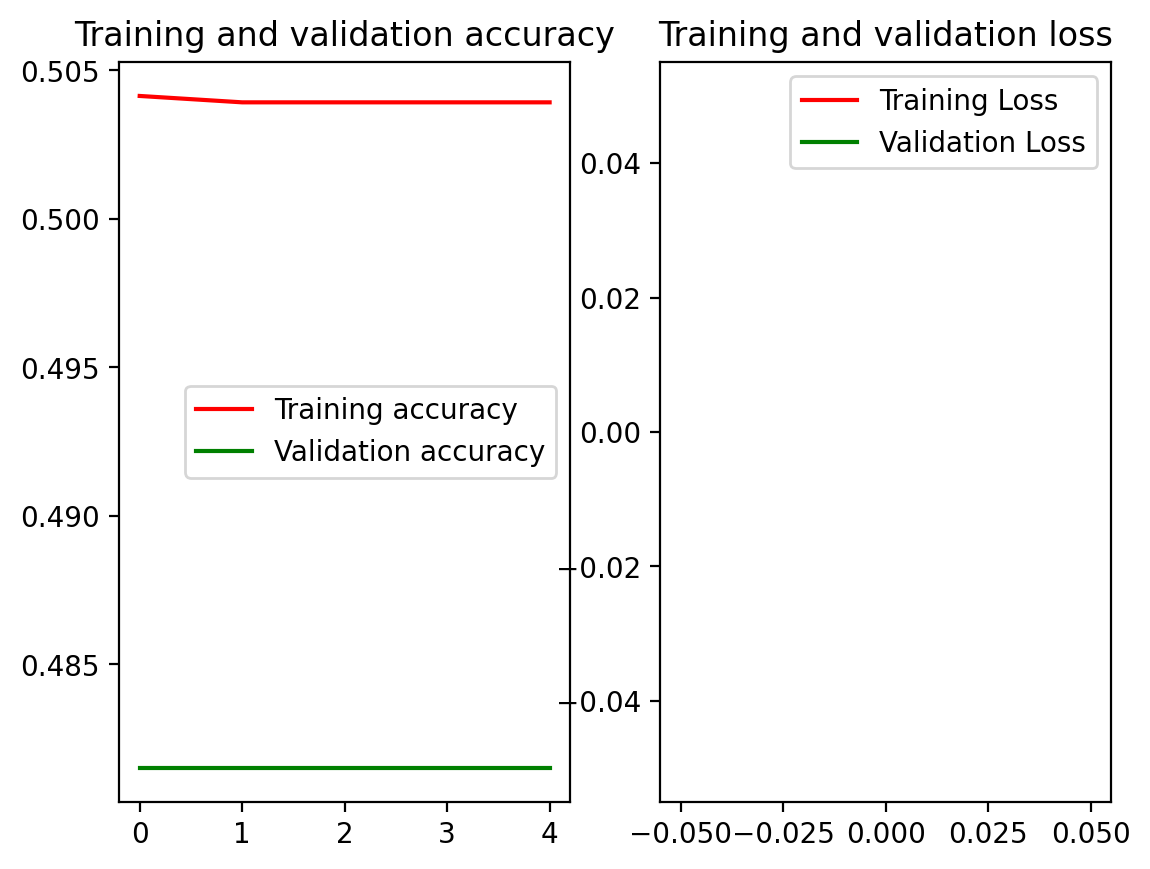

<Figure size 640x480 with 0 Axes>

In [46]:
# 정확도와 손실 확인
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.show()

### DenseNet 전이학습

In [57]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout

# DenseNet121 모델 불러오기 (이미 학습된 가중치를 사용)
base_model = DenseNet121(input_shape=(160, 160, 3), include_top=False, weights='imagenet')

# DenseNet121의 합성곱층을 동결
for layer in base_model.layers:
    layer.trainable = False

# 모델 구성
model = Sequential([
    base_model,
    Flatten(),
    Dense(units=512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(units=2, activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


29084464/29084464 [==============================] - 0s 0us/step


In [58]:
learning_rate = 0.0001

In [59]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [60]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [61]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [62]:
#학습 전 정확도 측정
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss : {:.2f}".format(loss0))
print("initial accuracy : {:.2f}".format(accuracy0))

20/20 [==============================] - 8s 79ms/step - loss: 1.5038 - accuracy: 0.5172
initial loss : 1.50
initial accuracy : 0.52


In [63]:
#학습 후 정확도 4에팍
EPOCHS = 5
history = model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 54s 80ms/step - loss: 0.0980 - accuracy: 0.9718 - val_loss: 0.0502 - val_accuracy: 0.9828
Epoch 2/5
582/582 [==============================] - 42s 71ms/step - loss: 0.0476 - accuracy: 0.9839 - val_loss: 0.0375 - val_accuracy: 0.9880
Epoch 3/5
582/582 [==============================] - 43s 72ms/step - loss: 0.0333 - accuracy: 0.9885 - val_loss: 0.0373 - val_accuracy: 0.9862
Epoch 4/5
582/582 [==============================] - 45s 75ms/step - loss: 0.0277 - accuracy: 0.9910 - val_loss: 0.0377 - val_accuracy: 0.9871
Epoch 5/5
582/582 [==============================] - 42s 71ms/step - loss: 0.0205 - accuracy: 0.9931 - val_loss: 0.0386 - val_accuracy: 0.9862


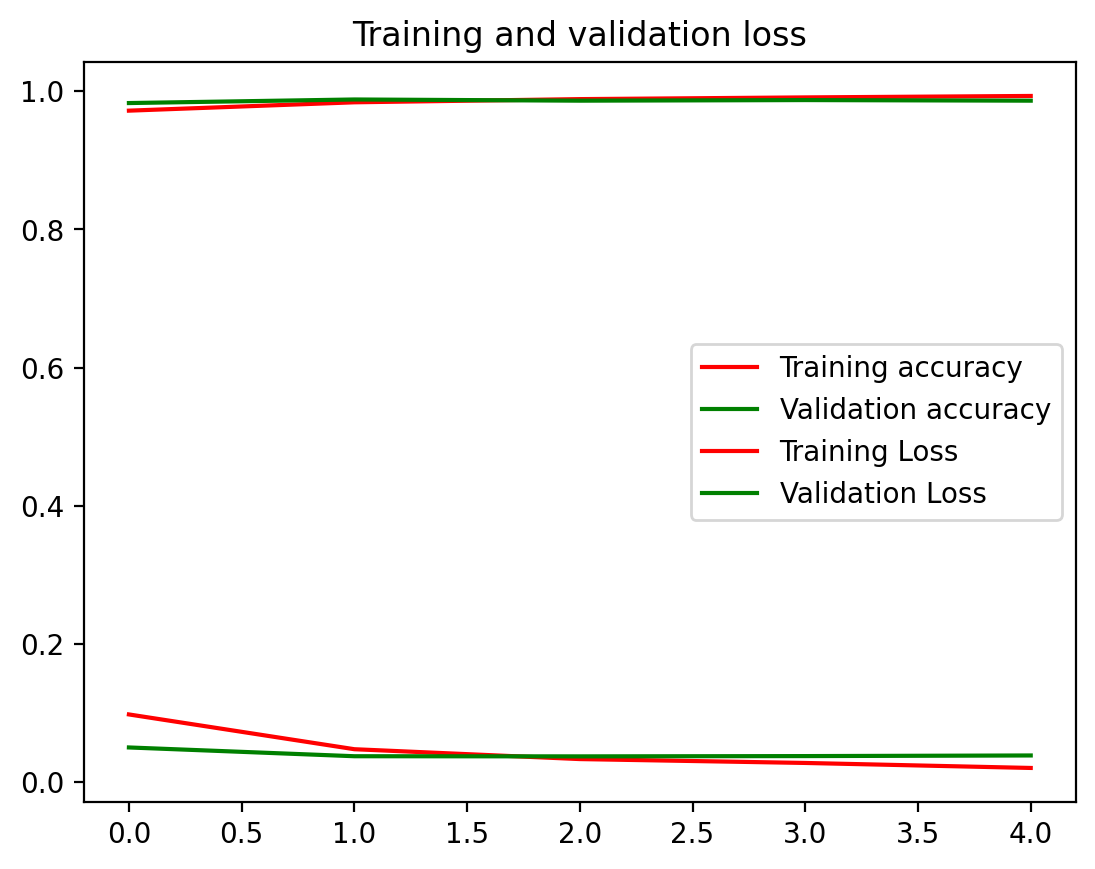

<Figure size 640x480 with 0 Axes>

In [66]:
# 정확도와 손실 확인
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.show()